<a href="https://colab.research.google.com/github/westjiuuu/CNN/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [ ]:
# 장치 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# 데이터셋 불러오기
train_dataset = torchvision.datasets.FashionMNIST(
    root="FashionMNIST/", download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.FashionMNIST(
    root="FashionMNIST/", download=True, train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.89MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 20.1MB/s]


In [ ]:

# 라벨 이름 매핑
labels_map = {
    0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'
}

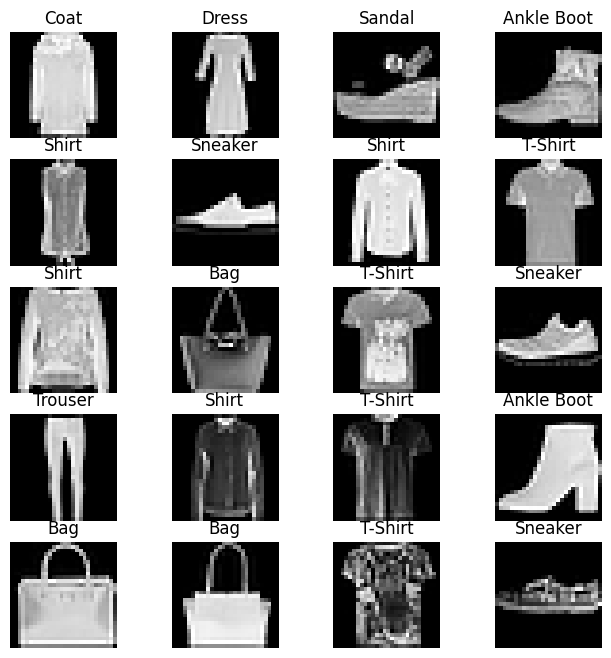

In [ ]:
# 데이터 시각화
fig = plt.figure(figsize=(8, 8))
columns, rows = 4, 5
for i in range(1, columns * rows + 1):
    img_idx = np.random.randint(len(train_dataset))
    img = train_dataset[img_idx][0][0, :, :]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_idx][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
# CNN 모델 정의
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(64 * 6 * 6, 600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [ ]:
# 학습 설정
model = FashionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 학습
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        train = Variable(images)
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if count % 50 == 0:
            total = 0
            correct = 0
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    predictions = torch.max(outputs, 1)[1]
                    correct += (predictions == labels).sum().item()
                    total += labels.size(0)

            accuracy = 100 * correct / total
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if count % 500 == 0:
            print(f"Iteration: {count}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.4520, Accuracy: 88.28%
Iteration: 1000, Loss: 0.3257, Accuracy: 89.10%
Iteration: 1500, Loss: 0.2089, Accuracy: 89.10%
Iteration: 2000, Loss: 0.2628, Accuracy: 89.69%
Iteration: 2500, Loss: 0.1220, Accuracy: 90.16%
Iteration: 3000, Loss: 0.1632, Accuracy: 90.36%
